# FunOS module initialization analysis

This notebook analyze module initilzation, durations and dependencies.
Input file is `modules.json`.

**References** for the notebook:
- [Using simple barh based implementation](https://towardsdatascience.com/gantt-charts-with-pythons-matplotlib-395b7af72d72)
- [Barh based with hints on how to make better representation](https://medium.com/geekculture/generate-gantt-chart-in-python-9d1e1fe9103e)

NEXT:
- have it a way to generate web page
- generate output from f1
- may require manual packing
- check plotly one more time (just use line chart ?) or use gannt style, which requre datetime conversion

In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
def convert_to_list_of_dicts(raw_data: dict, convert_time_to_ns: bool, debug: bool) -> list:
    """convert the raw data (dict based format) to list of dicts

    Parameters
    ----------
    raw_data : dict
        raw data in dict format, module_name: [start_time, end_time]
    
    convert_time_to_ns : bool, optional
        convert time to ns, by default True
    
    Returns
    -------
    fun_module_init_list : list
        list of dicts, each dict is a module, with keys: module_name, start_time, finish_time
    """
    time_unit = 0
    if convert_time_to_ns:
        time_unit = 1000000000
    fun_module_init_list = []
    for module_name, module_data in raw_data.items():
        temp_dict = {}
        temp_dict['module_name'] = module_name
        temp_dict['start_time'] = time_unit * float(module_data[0])
        temp_dict['finish_time'] = time_unit * float(module_data[1])
        # add duration column
        temp_dict['module_init_duration'] = temp_dict['finish_time'] - temp_dict['start_time']
        fun_module_init_list.append(temp_dict)

    if debug:
        print("List created")
        print(fun_module_init_list[:2])
        print("Time conversion unit: {}".format(time_unit))
        # convert list of dicts to pandas dataframe
        # fun_module_init_df = pd.DataFrame(fun_module_init_list)
        # fun_module_init_df.head()
    
    return fun_module_init_list

In [3]:
def load_input_data(input_file: str, convert_time_to_ns: bool = True, debug: bool=False) -> pd.DataFrame:
    """load input data from json file and convert to pandas dataframe

    Parameters
    ----------
    input_file : str
        input file name
    
    Returns
    -------

    fun_module_init_df : pd.DataFrame
        pandas dataframe with module_name, start_time, finish_time, module_init_duration

    """
    with open(input_file, 'r') as f:
        fun_module_init = json.load(f)
    
    if debug:
        print("Number of modules: {}".format(len(fun_module_init)))
        print("fun_module_init.keys: {}".format(fun_module_init.keys()))
        print("fun_module_init['accel_telem-init']: {}".format(fun_module_init['accel_telem-init']))

    # convert to list of dicts
    fun_module_init_list = convert_to_list_of_dicts(fun_module_init, convert_time_to_ns=convert_time_to_ns, debug=debug)

    # convert to df
    fun_module_init_df = pd.DataFrame(fun_module_init_list)
    fun_module_init_df.set_index('module_name', inplace=True)

    return fun_module_init_df


## Load raw json file and convert it to dataframe

Example input:
```
{
    "accel_telem-init": [0.024845458, 0.024987833],
    "adi-init": [0.040308791, 0.040344291],
    "app-init": [0.029524875, 0.029535041],
...
```

Example output:
```
	module_name	start_time	finish_time
0	accel_telem-init	0.024845	0.024988
1	adi-init	0.040309	0.040344
2	app-init	0.029525	0.029535
3	bin_ctl_handler-init	0.002356	0.002492
4	bm-init	0.030727	0.030735
```

In [4]:
# load config, TODO use config file

INPUT_FILE = "modules.json"

In [5]:
# MAIN CALLS
# load input data

fun_module_init_df = load_input_data(INPUT_FILE, convert_time_to_ns=True, debug=False)
fun_module_init_df.head()

,start_time,finish_time,module_init_duration
module_name,,,
accel_telem-init,24845458.0,24987833.0,142375.0
adi-init,40308791.0,40344291.0,35500.0
app-init,29524875.0,29535041.0,10166.0
bin_ctl_handler-init,2355583.0,2492166.0,136583.0
bm-init,30726791.0,30735416.0,8625.0


In [6]:
print("module init summary: time in ns")
fun_module_init_df.describe().round()

module init summary: time in ns


,start_time,finish_time,module_init_duration
count,83.0,83.0,83.0
mean,34911058.0,37167342.0,2256284.0
std,47729428.0,50534131.0,11696933.0
min,50208.0,58708.0,4584.0
25%,6286042.0,6293646.0,14438.0
50%,26320541.0,26407333.0,70375.0
75%,30746270.0,30776396.0,177624.0
max,200082875.0,200089500.0,89382792.0


In [7]:
print("Total number of modules: {}".format(len(fun_module_init_df)))

Total number of modules: 83


In [8]:
# time experiment

import time    
epoch_time = int(time.time())
print("Epoch time: {}".format(epoch_time))

Epoch time: 1663883492


In [9]:
import time

ms = time.time_ns() // 1_000_000
print("ms: {}".format(ms))
type(ms)


ms: 1663883492737


int

## Plot events

In [10]:
import plotly.express as px
import pandas as pd

In [40]:
def get_start_finish_times(df: pd.DataFrame, debug: bool = False) -> pd.DataFrame:
    """Utility to get start and finish times from df"""

    start_min = df['start_time'].min() # first module start time
    finish_max = df['finish_time'].max() # last module finish time
    duration = finish_max - start_min # time between the first module start time and last module finish time

    if debug:
        print("start_min (start time of the first module): {}".format(start_min))
        print("finish_max: (finish time of the last module) {}".format(finish_max))
        # print("duration: (finish_max - start_min) {}".format(finish_max - start_min))
        # summary
        total_module_time = df['module_init_duration'].sum()
        print("Total module init time: {} ns".format(total_module_time))
        print("duration (time between the first module start time and last module finish time): {} ns".format(finish_max - start_min))
        print("'Total module init time' / 'duration' (greater than 1 is better, which means more concurrent modules init): {} ".format(((total_module_time / duration)).round(4)))
    
    return start_min, finish_max, duration

In [41]:
def plot_module_time_chart(df: pd.DataFrame, use_plt: bool=True, sort_by: str="start_time", title: str='FunOS Module Init Duration', save_file_name: str ="fun_module_init_chart.png", debug: bool=False) -> None:
    """Plot the module init time chart
    Parameters
    ----------
    df : pd.DataFrame
        dataframe with module init data
    sort_by : str, optional
        sort by column, by default "start_time"
    title : str, optional
        title of the chart, by default 'FunOS Module Init Duration'
    Returns
    -------
    None
    """
    # add max min for creating tick

    df_use = df.copy()

    X_disp_granualarity = 10
    X_granualarity = 1000000
    x_tick_str = "ms"
    # if X_granualarity == 1000000:
    #     x_tick_str = "ms"
    # elif X_granualarity == 1000000000:
    #     x_tick_str = "s"

    start_min, finish_max, duration = get_start_finish_times(df_use, debug=debug)

    x_ticks = np.arange(0, duration, X_disp_granualarity * X_granualarity)
    x_tick_labels = ["{} {}".format(str(int(x)), x_tick_str) for x in x_ticks/X_granualarity]
    
    if debug:
        print("x_ticks: {}".format(x_ticks[:10]))
        print("x_tick_labels: {}".format(x_tick_labels[:10]))

    df_use.sort_values(by=[sort_by], inplace=True, ascending=True)
    if debug:
        display(df_use.head())
        display(df_use.describe())

    if use_plt:
        fig, ax = plt.subplots(1, figsize=(40, 50))
        ax.barh(df_use.index, width=df_use['module_init_duration'], left=df_use['start_time'])

        #Invert y axis
        plt.gca().invert_yaxis()

        #customize x-ticks
        plt.xticks(ticks=x_ticks, labels=x_tick_labels)

        # title
        plt.title(title, fontsize=20)

        #rotate x-ticks
        plt.xticks(rotation=60)
        #add grid lines
        plt.grid(axis='x', alpha=0.5)
        plt.grid(axis='y', alpha=0.5)

        #save fig
        plt.savefig(save_file_name)
        plt.show()
    else:
        # use plotly
        # plotly doesn't support 'left' argument, so need to create manualy bars
        # https://community.plotly.com/t/broken-barh-plot/36496
        assert False, "Ploty not supported yet"
        fig = px.timeline(df, x_start="start_time", x_end="finish_time", y=df_use.index, title=title)
        fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
        fig.show()

    del df_use

start_min (start time of the first module): 50208.0
finish_max: (finish time of the last module) 200089500.0
Total module init time: 187271539.0 ns
duration (time between the first module start time and last module finish time): 200039292.0 ns
'Total module init time' / 'duration' (greater than 1 is better, which means more concurrent modules init): 0.9362 
x_ticks: [       0. 10000000. 20000000. 30000000. 40000000. 50000000. 60000000.
 70000000. 80000000. 90000000.]
x_tick_labels: ['0 ms', '10 ms', '20 ms', '30 ms', '40 ms', '50 ms', '60 ms', '70 ms', '80 ms', '90 ms']


,start_time,finish_time,module_init_duration
module_name,,,
modcfg-init,50208.0,58708.0,8500.0
dma_utils-init,160041.0,268541.0,108500.0
hw_dmae_sim-init,223041.0,239666.0,16625.0
hw_emmc-init,515458.0,569875.0,54417.0
hw_hu_cfg-init,565083.0,2349041.0,1783958.0


,start_time,finish_time,module_init_duration
count,8.300000e+01,8.300000e+01,8.300000e+01
mean,3.491106e+07,3.716734e+07,2.256284e+06
std,4.772943e+07,5.053413e+07,1.169693e+07
min,5.020800e+04,5.870800e+04,4.584000e+03
25%,6.286042e+06,6.293646e+06,1.443750e+04
50%,2.632054e+07,2.640733e+07,7.037500e+04
75%,3.074627e+07,3.077640e+07,1.776245e+05
max,2.000829e+08,2.000895e+08,8.938279e+07


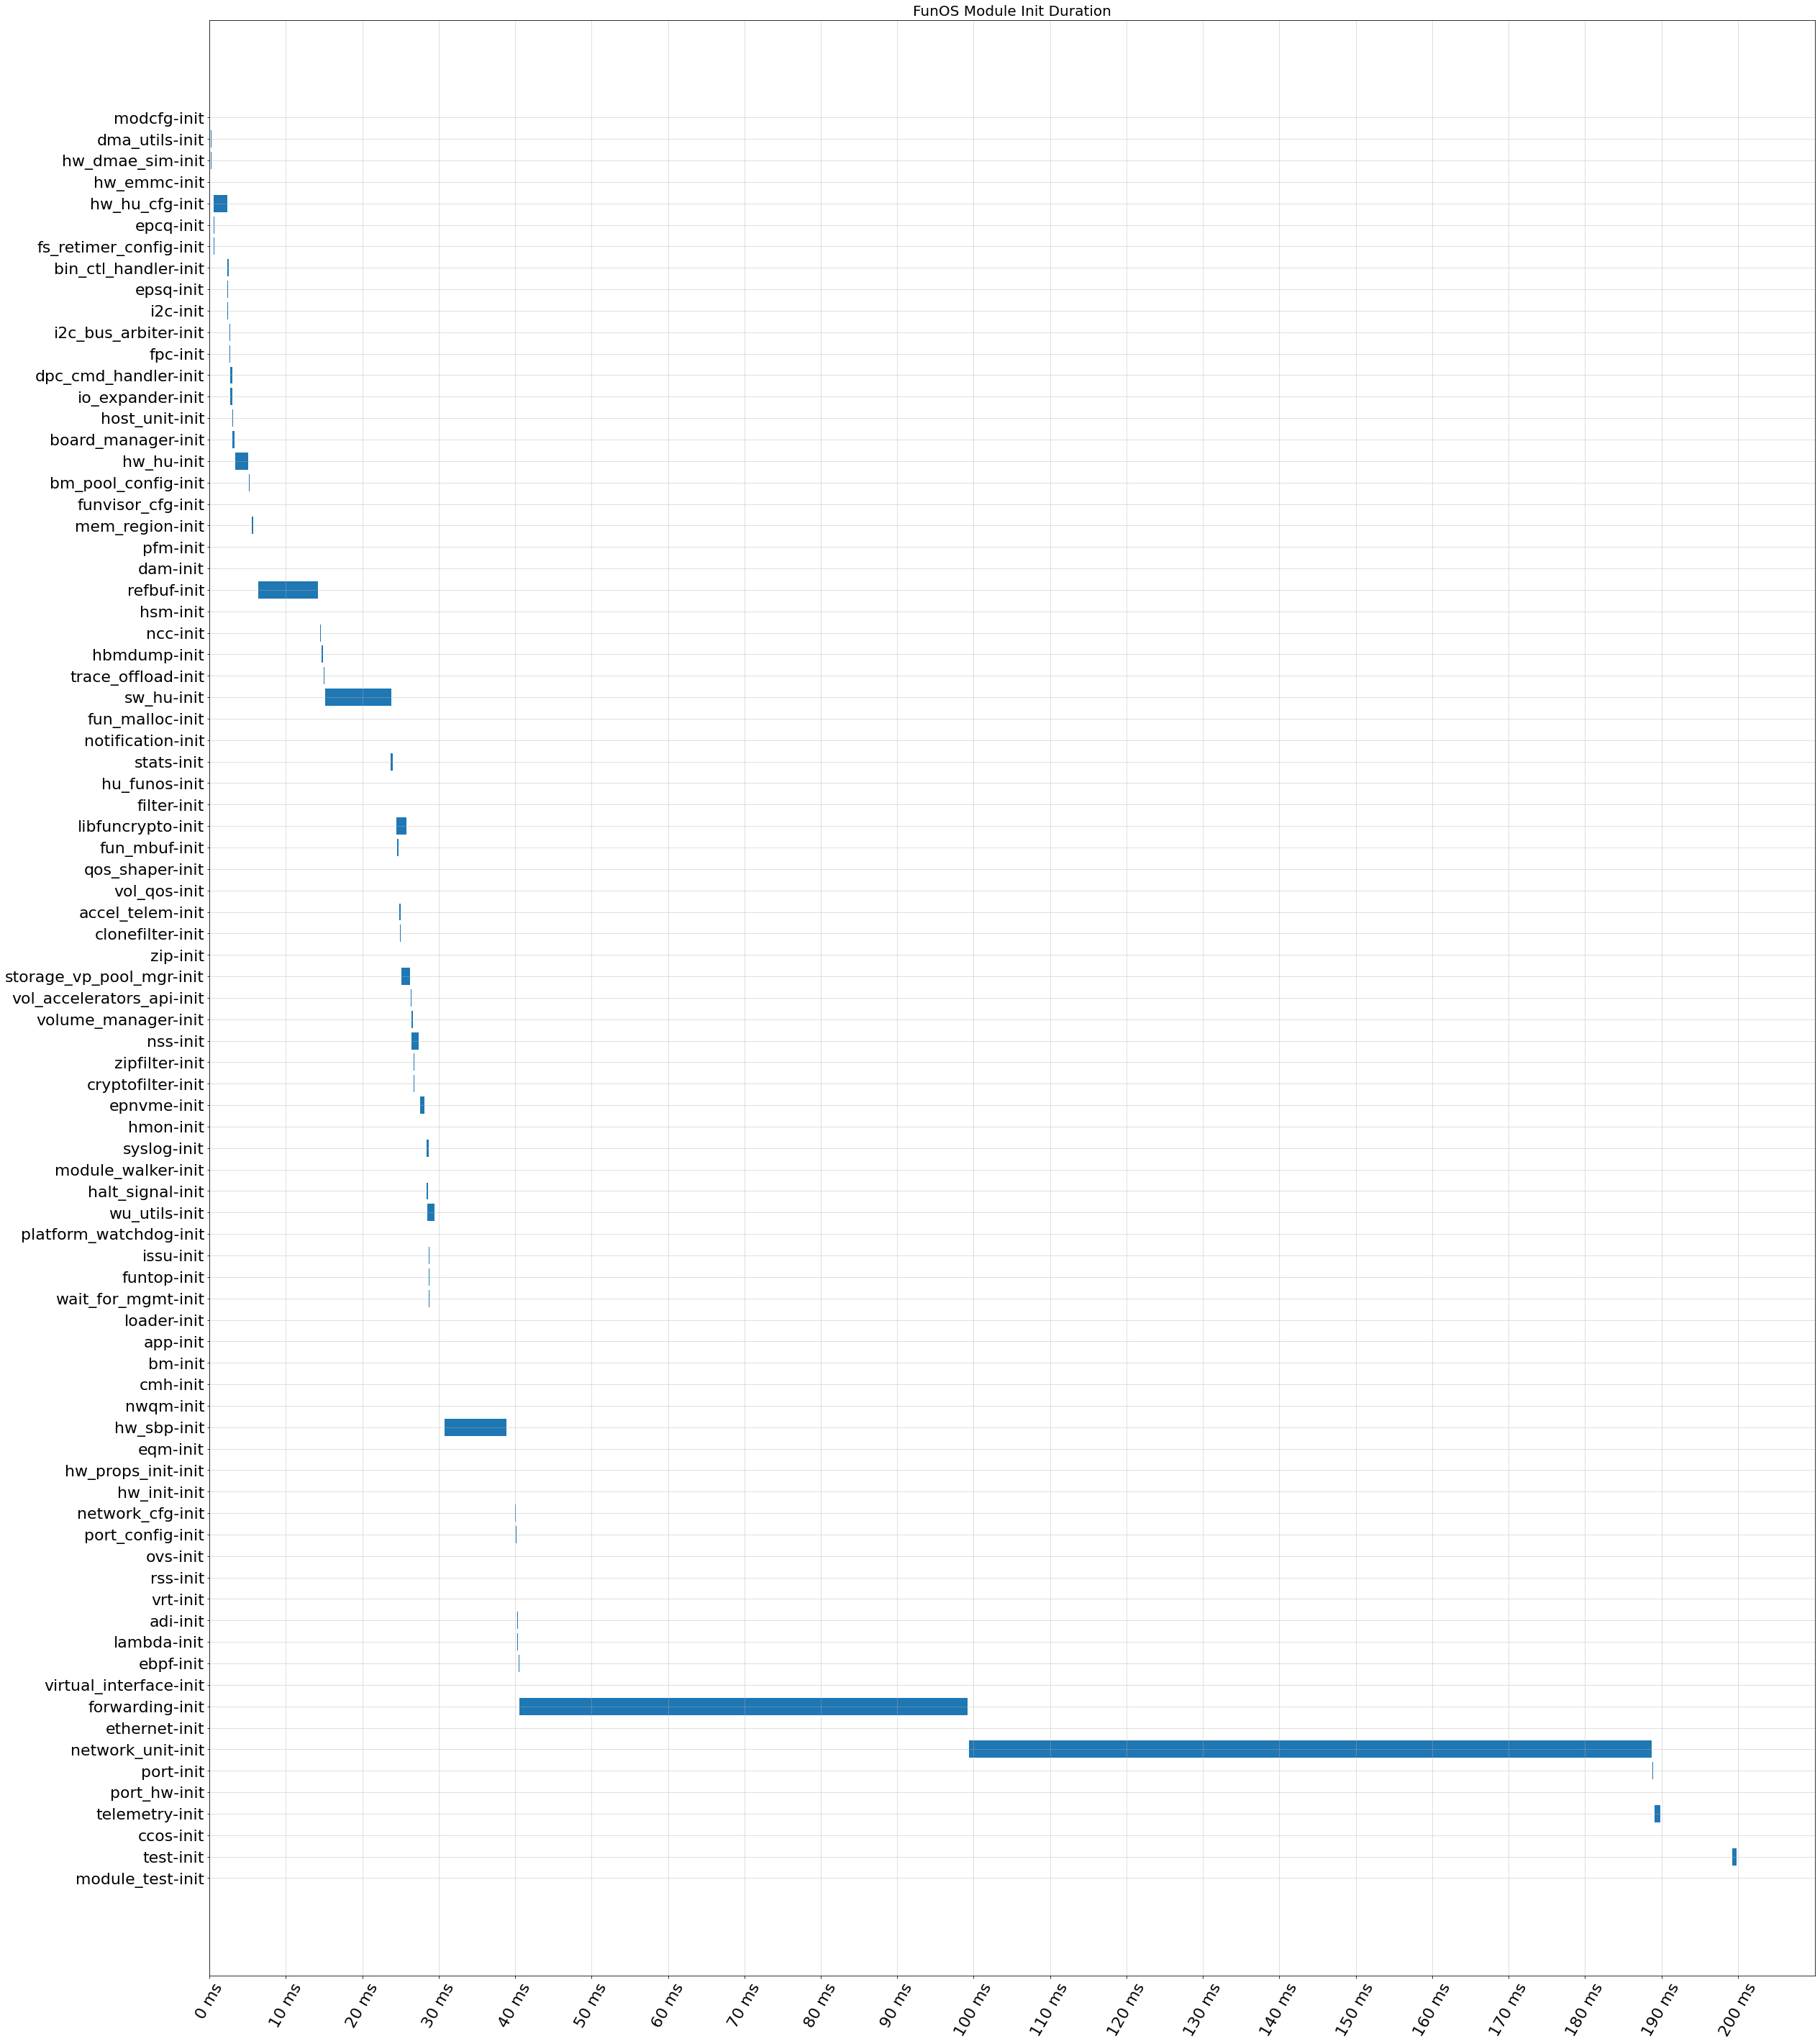

In [42]:
# MAIN CALLS
# plot the events
plot_module_time_chart(fun_module_init_df, debug=True)

In [15]:
fun_module_init_df.loc[['forwarding-init', 'network_unit-init', 'ethernet-init']]
# fun_module_init_df.index
# fun_module_init_df.columns

,start_time,finish_time,module_init_duration
module_name,,,
forwarding-init,40587541.0,99232375.0,58644834.0
network_unit-init,99351791.0,188734583.0,89382792.0
ethernet-init,99276375.0,99303375.0,27000.0
